In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os.path
import urllib.request 

In [64]:
#Define the data directory and file paths
#Create a directory for data if it doesn't exist
DATA_DIR = "data/"
os.makedirs(DATA_DIR, exist_ok=True)

ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
MMC1_PATH = os.path.join(DATA_DIR, "mmc1.xlsx")
REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")

#Check if data files are already downloaded and if not, download them
#ATAC-seq
if not os.path.isfile(ATAC_SEQ_PATH):
    urllib.request.urlretrieve("https://sharehost.hms.harvard.edu/immgen/ImmGenATAC18_AllOCRsInfo.csv", ATAC_SEQ_PATH)

#RNA-seq    
if not os.path.isfile(RNA_SEQ_PATH):
    urllib.request.urlretrieve("https://www.cell.com/cms/10.1016/j.cell.2018.12.036/attachment/4392da81-c56e-471a-b1df-0e72f03ecd77/mmc2.csv", RNA_SEQ_PATH)

if not os.path.isfile(MMC1_PATH):
    urllib.request.urlretrieve("https://www.cell.com/cms/10.1016/j.cell.2018.12.036/attachment/e5df7329-d77d-40b3-a03a-34bdbe4b402c/mmc1.xlsx", MMC1_PATH)
    
if not os.path.isfile(REFFLAT_PATH):
    urllib.request.urlretrieve("http://hgdownload.cse.ucsc.edu/goldenPath/mm10/database/refFlat.txt.gz", REFFLAT_PATH)

#Load the ATAC-seq data
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2])
#atac.index.names = ["peakID", "chrom"]

#Load the RNA-seq data
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)

#Load the meta data
meta = pd.read_excel(MMC1_PATH)
meta = meta.set_index("SampleName")

#Load the annotation data
refFlat = pd.read_csv(REFFLAT_PATH, sep="\t", header=None, comment="#", compression="gzip")
refFlat.columns = ["geneName", "name", "chrom", "strand", "txStart", "txEnd",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"]

c:\Users\luisw\miniconda3\envs\data_analysis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


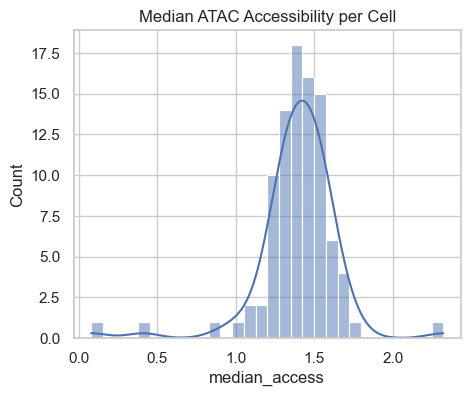

,mean_access,median_access,std_access,PF.reads,InputCellNumber
mm10.60way.phastCons_scores,0.164662,0.08,0.203403,NaN,NaN
_-log10_bestPvalue,inf,2.32,NaN,NaN,NaN
Included.in.systematic.analysis,1.000000,1.00,0.000000,NaN,NaN
LTHSC.34-.BM,3.868438,0.41,10.004101,22287984.0,677.0
LTHSC.34+.BM,4.005767,1.64,9.986633,28588536.0,2483.0
...,...,...,...,...,...
FRC.SLN,3.998828,1.47,9.808067,NaN,NaN
IAP.SLN,3.987949,1.40,9.614775,47040542.0,20000.0
BEC.SLN,3.983416,1.54,9.709456,73428210.0,20000.0
LEC.SLN,3.976234,1.57,9.715224,60787252.0,20000.0


In [65]:
sns.set_theme(style="whitegrid")

# 1. Compute per‐cell stats
cell_stats = pd.DataFrame({
    "mean_access":   atac.mean(axis=0, numeric_only=True),
    "median_access": atac.median(axis=0, numeric_only=True),
    "std_access":    atac.std(axis=0, numeric_only=True)
})
# join QC metrics
for col in ["PF.reads","InputCellNumber","TSS.enrichment"]:
    if col in meta.columns:
        cell_stats[col] = meta.groupby("CellType").sum()[col]

# 2. Visualize
plt.figure(figsize=(5,4))
sns.histplot(cell_stats["median_access"], bins=30, kde=True)
plt.title("Median ATAC Accessibility per Cell")
plt.show()
cell_stats

In [66]:

# 3. Correlation
print("Corr mean_access vs PF.reads:",
      cell_stats["mean_access"].corr(cell_stats.get("PF.reads")))
print("Corr mean_access vs InputCellNumber:",
      cell_stats["mean_access"].corr(cell_stats.get("InputCellNumber")))

Corr mean_access vs PF.reads: 0.2141220101720246
Corr mean_access vs InputCellNumber: 0.10703405767604873


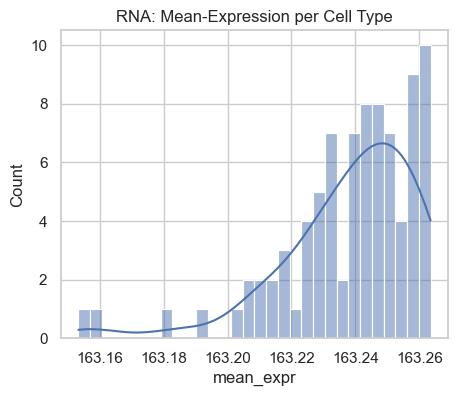

,mean_expr,median_expr,std_expr,PF.reads
LTHSC.34-.BM,163.261162,22.788066,576.884525,22287984.0
LTHSC.34+.BM,163.261089,23.117322,576.925735,28588536.0
STHSC.150-.BM,163.260318,23.353421,577.574457,22170346.0
MPP4.135+.BM,163.260179,22.886122,577.409321,24003590.0
proB.CLP.BM,163.258616,23.643738,571.296896,43806828.0
...,...,...,...,...
FRC.SLN,163.262712,23.519148,576.022402,NaN
IAP.SLN,163.262576,24.950026,568.594767,47040542.0
BEC.SLN,163.262353,23.488316,573.821391,73428210.0
LEC.SLN,163.263143,23.127040,575.874869,60787252.0


In [67]:

rna_cell_stats = pd.DataFrame({
    "mean_expr":   rna.mean(axis=0),
    "median_expr": rna.median(axis=0),
    "std_expr":    rna.std(axis=0)
})
# Merge QC if desired (e.g. InputCellNumber)
if "PF.reads" in meta.columns:
    rna_cell_stats["PF.reads"] = meta.groupby("CellType")["PF.reads"].sum()

plt.figure(figsize=(5,4))
sns.histplot(rna_cell_stats["mean_expr"], bins=30, kde=True)
plt.title("RNA: Mean-Expression per Cell Type")
plt.show()
rna_cell_stats

In [68]:
print("Corr mean_access vs PF.reads:",
      cell_stats["mean_access"].corr(cell_stats.get("PF.reads")))

Corr mean_access vs PF.reads: 0.2141220101720246


In [72]:
# 4.1 Peak stats
peak_stats = pd.DataFrame({
    "mean_access": atac.mean(axis=1, numeric_only=True),
    "var_access":  atac.var(axis=1, numeric_only=True),
    "cv_access":   atac.std(axis=1, numeric_only=True)/(atac.mean(axis=1, numeric_only=True)+1e-6)
})

peak_stats

c:\Users\luisw\miniconda3\envs\data_analysis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\luisw\miniconda3\envs\data_analysis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,,,mean_access,var_access,cv_access
ImmGenATAC1219.peakID,chrom,Summit,,,
ImmGenATAC1219.peak_1,chr1,3020786,1.036739,1.006191,0.967543
ImmGenATAC1219.peak_2,chr1,3087226,0.914239,0.742985,0.942822
ImmGenATAC1219.peak_3,chr1,3120109,1.599570,44.595600,4.174866
ImmGenATAC1219.peak_4,chr1,3121485,0.891183,2.331189,1.713253
ImmGenATAC1219.peak_5,chr1,3372787,0.877500,0.662129,0.927307
...,...,...,...,...,...
ImmGenATAC1219.peak_512591,chrY,90812450,6.766022,24.083624,0.725316
ImmGenATAC1219.peak_512592,chrY,90812906,6.814731,19.657464,0.650601
ImmGenATAC1219.peak_512593,chrY,90813175,1.673370,1.219724,0.659992
